In [1]:
!pip install torch torchvision tqdm

In [ ]:
## SET LIBRARY

In [7]:
import os, time
from glob import glob
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## LOAD DATA

In [ ]:
#!pwd
#!gsutil cp gs://supark-sandbox/BelgiumTSC_Training.zip ./
#!unzip BelgiumTSC_Training.zip
#!mv Training train
#!gsutil cp gs://supark-sandbox/BelgiumTSC_Testing.zip ./
#!unzip BelgiumTSC_Testing.zip
#!mv Testing valid

In [27]:
idx_train = {}
idx_valid = {}
for i in ('train','valid'):
    path = os.path.join('/jet/prs/workspace/',i)
    paths = [sub for sub in os.listdir(path) if os.path.isdir(os.path.join(path, sub))]
    print('Label size: {}'.format(len(paths)))
    for p in paths:
        files = glob(os.path.join(path, p, '*.ppm'))
        #print('Label {} size: {}'.format(p, len(files)))
        if i == 'train':
            idx_train[str(p)] = len(files)
        else:
            idx_valid[str(p)] = len(files)
idx_lbl = pd.concat([pd.Series(idx_train),pd.Series(idx_valid)], axis=1, join='inner')
idx_lbl.columns = ('train','valid')
idx_lbl.head()

Label size: 62
Label size: 62


,train,valid
00000,15,6
00001,110,27
00002,13,7
00003,15,6
00004,15,12


In [37]:
# from torchvision import transforms
path = '/jet/prs/workspace/'
transform_fn = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder(os.path.join(path,'train'), transform_fn)
valid = ImageFolder(os.path.join(path,'valid'), transform_fn)

In [38]:
print(train.class_to_idx)
print(train.classes)

{'00000': 0, '00001': 1, '00002': 2, '00003': 3, '00004': 4, '00005': 5, '00006': 6, '00007': 7, '00008': 8, '00009': 9, '00010': 10, '00011': 11, '00012': 12, '00013': 13, '00014': 14, '00015': 15, '00016': 16, '00017': 17, '00018': 18, '00019': 19, '00020': 20, '00021': 21, '00022': 22, '00023': 23, '00024': 24, '00025': 25, '00026': 26, '00027': 27, '00028': 28, '00029': 29, '00030': 30, '00031': 31, '00032': 32, '00033': 33, '00034': 34, '00035': 35, '00036': 36, '00037': 37, '00038': 38, '00039': 39, '00040': 40, '00041': 41, '00042': 42, '00043': 43, '00044': 44, '00045': 45, '00046': 46, '00047': 47, '00048': 48, '00049': 49, '00050': 50, '00051': 51, '00052': 52, '00053': 53, '00054': 54, '00055': 55, '00056': 56, '00057': 57, '00058': 58, '00059': 59, '00060': 60, '00061': 61}
['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '000

In [39]:
def imshow(tnsr):
    tnsr = tnsr.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tnsr = std * tnsr + mean
    tnsr = np.clip(tnsr, 0, 1)
    plt.imshow(tnsr)

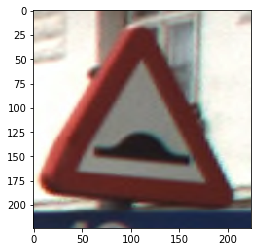

In [40]:
imshow(train[50][0])

In [41]:
g_train = DataLoader(train, batch_size=64, num_workers=3, shuffle=True)
g_valid = DataLoader(valid, batch_size=64, num_workers=3, shuffle=True)
dataloader = {'train': g_train, 'valid': g_valid}
dataset_sizes = {'train':len(g_train.dataset),'valid':len(g_valid.dataset)}

In [ ]:
## SET GRAPH

In [42]:
GPH = models.resnet18(pretrained=True)
num_ftrs = GPH.fc.in_features
GPH.fc = nn.Linear(num_ftrs, 62)

if torch.cuda.is_available():
    GPH = GPH.cuda()

In [ ]:
## TRAIN

In [43]:
learning_rate = 0.001
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(GPH.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [44]:
def train_gph(gph, loss, optimizer, scheduler, num_epochs=1):
    bgn_tms = time.time()

    best_gph_wts = gph.state_dict()
    best_acc = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ('train', 'valid'):
            if phase == 'train':
                scheduler.step()
                gph.train(True)
            else:
                gph.train(False)

            running_loss = 0.0
            running_corrects = 0
            running_counts = 0

            for data in dataloader[phase]:
                x_input, y_label = data

                if torch.cuda.is_available():
                    x_input = Variable(x_input.cuda())
                    y_label = Variable(y_label.cuda())
                else:
                    x_input, y_label = Variable(x_input), Variable(y_label)

                optimizer.zero_grad()

                y_prob = gph(x_input)
                _, y_pred = torch.max(y_prob, 1)
                loss = Loss(y_prob, y_label)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(y_pred == y_label.data).item()
                running_counts += len(y_pred)

            epoch_loss = running_loss / running_counts
            epoch_acc = running_corrects / running_counts
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_gph_wts = gph.state_dict()

        print()

    time_elapsed = time.time() - bgn_tms
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    gph.load_state_dict(best_gph_wts)
    return gph

In [46]:
gph = train_gph(GPH, Loss, optimizer, scheduler, num_epochs=16)

Epoch 0/15
----------
train Loss: 0.0102 Acc: 0.8844
valid Loss: 0.0089 Acc: 0.9091

Epoch 1/15
----------
train Loss: 0.0067 Acc: 0.9226
valid Loss: 0.0068 Acc: 0.9274

Epoch 2/15
----------
train Loss: 0.0047 Acc: 0.9484
valid Loss: 0.0054 Acc: 0.9389

Epoch 3/15
----------
train Loss: 0.0034 Acc: 0.9701
valid Loss: 0.0044 Acc: 0.9520

Epoch 4/15
----------
train Loss: 0.0025 Acc: 0.9840
valid Loss: 0.0036 Acc: 0.9651

Epoch 5/15
----------
train Loss: 0.0021 Acc: 0.9886
valid Loss: 0.0036 Acc: 0.9651

Epoch 6/15
----------
train Loss: 0.0020 Acc: 0.9893
valid Loss: 0.0036 Acc: 0.9627

Epoch 7/15
----------
train Loss: 0.0020 Acc: 0.9891
valid Loss: 0.0034 Acc: 0.9647

Epoch 8/15
----------
train Loss: 0.0019 Acc: 0.9899
valid Loss: 0.0035 Acc: 0.9647

Epoch 9/15
----------
train Loss: 0.0019 Acc: 0.9904
valid Loss: 0.0035 Acc: 0.9655

Epoch 10/15
----------
train Loss: 0.0018 Acc: 0.9899
valid Loss: 0.0034 Acc: 0.9663

Epoch 11/15
----------
train Loss: 0.0018 Acc: 0.9895
valid Loss